In [1]:
#Import Libraries
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline

In [2]:
#Load the Dataset
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

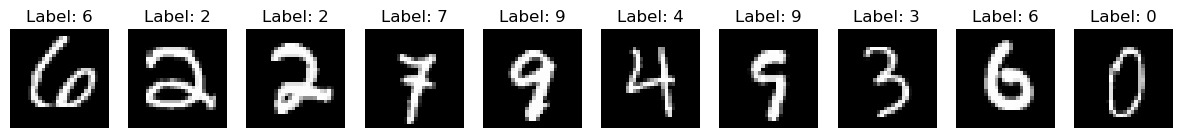

In [3]:
#Initial Visualization of Images
# Step 1: Extract pixel data and labels from the training DataFrame
X = train_df.drop("label", axis=1).values  # Extract pixel values
y = train_df["label"].values               # Extract labels

# Step 2: Normalize pixel values to the range [0, 1]
X = X / 255.0

# Step 3: Plot several sample images with their corresponding labels
import matplotlib.pyplot as plt

def plot_samples(X, y, n=10):
    """
    Display n random samples from the dataset.
    Each image is reshaped into 28x28 pixels.
    """
    plt.figure(figsize=(15, 2))
    indices = np.random.choice(len(X), n, replace=False)
    for i, idx in enumerate(indices):
        image = X[idx].reshape(28, 28)
        label = y[idx]
        plt.subplot(1, n, i+1)
        plt.imshow(image, cmap="gray")
        plt.title(f"Label: {label}")
        plt.axis("off")
    plt.show()

# Call the function to visualize 10 random images
plot_samples(X, y)


In [4]:
#Data Preprocessing and Loader Creation

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

# Step 1: Separate features and labels
X = train_df.drop("label", axis=1).values.astype(np.float32)  # Shape: (n_samples, 784)
y = train_df["label"].values.astype(np.int64)                # Labels: integers 0-9

# Step 2: Normalize pixel values to [0, 1]
X = X / 255.0

# Step 3: Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# Step 4: Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)

X_val_tensor = torch.tensor(X_val)
y_val_tensor = torch.tensor(y_val)

# Step 5: Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Step 6: Create DataLoaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [5]:
#CNN Preprocessing (MNIST & EMNIST )
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from cnn_model import CNN # CNN Model
from data_utils import get_cnn_loader  # MNIST/EMNIST

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN(num_classes=10)  # change this to 47 for EMNIST testing
model.load_state_dict(torch.load("cnn_mnist.pt", map_location=device)) #change to cnn_emnist.pt for EMNIST testing
model.to(device)
model.eval()

C:\Users\thiag\AppData\Local\Temp\ipykernel_51992\4212909030.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cnn_mnist.pt", map_locatio

CNN(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Dropout(p=0.25, inplace=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=12544, out_features=128, bias=True)
    (11): ReLU()
    (12): Dropout(p=0.5, inplace=False)
    (13): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [7]:
test_loader = get_cnn_loader(dataset_name="MNIST", batch_size=16, train=False)

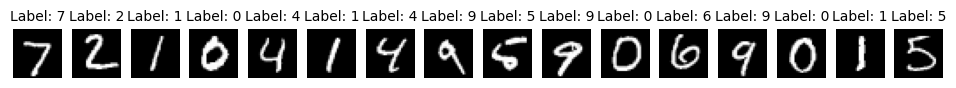

In [8]:
classes = [str(i) for i in range(10)]

def show_predictions(loader, model, num_batches=1):
    for i, (images, labels) in enumerate(loader):
        if i >= num_batches:
            break
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        images = images.cpu().numpy()
        preds = preds.cpu().numpy()
        labels = labels.cpu().numpy()

        plt.figure(figsize=(12, 3))
        for j in range(len(images)):
            plt.subplot(1, len(images), j+1)
            plt.imshow(images[j][0], cmap="gray")
            plt.title(f"Label: {classes[preds[j]]}", fontsize=10)
            plt.axis("off")
        plt.show()

show_predictions(test_loader, model)

In [9]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Test Accuracy: 98.89%


In [10]:
test_loader = get_cnn_loader(dataset_name="EMNIST", batch_size=16, train=False)

C:\Users\thiag\AppData\Local\Temp\ipykernel_51992\3357364414.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cnn_emnist.pt", map_locati

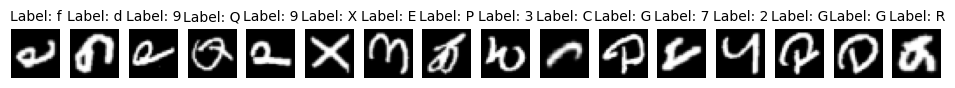

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(num_classes=47)  # EMNIST Balanced has 47 classes
model.load_state_dict(torch.load("cnn_emnist.pt", map_location=device))
model.to(device)
model.eval()

test_loader = get_cnn_loader(dataset_name="EMNIST", batch_size=16, train=False)

# EMNIST Balanced class labels: 0-9 (digits), 10-35 (uppercase), 36-61 (lowercase), 62-46 (other symbols)
classes = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'
][:47]

show_predictions(test_loader, model, num_batches=1)

In [12]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Test Accuracy: 86.34%


In [13]:
%run test_cnn.py

Evaluating MNIST...
MNIST Validation Accuracy: 0.9889
MNIST Validation Loss: 0.0353

Evaluating EMNIST...
EMNIST Validation Accuracy: 0.8634
EMNIST Validation Loss: 0.4008



<Figure size 640x480 with 0 Axes>


--- Evaluating MLP ---

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.96      0.98      0.97      1010
           4       0.98      0.97      0.97       982
           5       0.98      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.98      0.96      0.97       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Accuracy: 0.9759
Precision: 0.9759
Recall: 0.9759
F1 Score: 0.9759
Cross-Entropy Loss: 0.8687


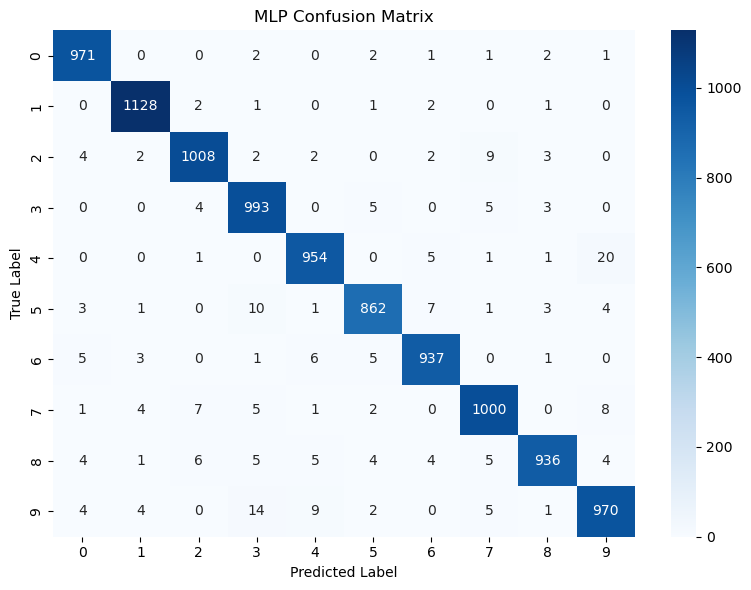


--- Evaluating CNN ---

Classification Report:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.98      0.99      0.99       982
           5       0.99      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.98      0.99       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

Accuracy: 0.9889
Precision: 0.9889
Recall: 0.9889
F1 Score: 0.9889
Cross-Entropy Loss: 0.4001


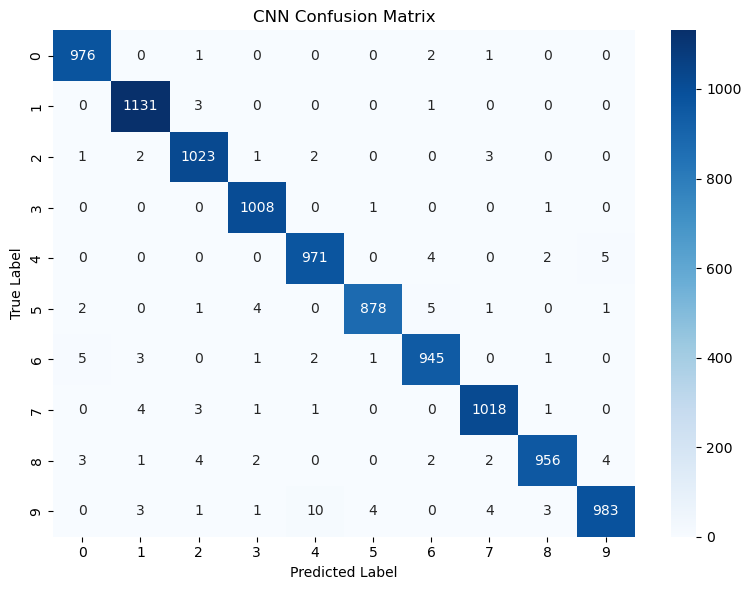

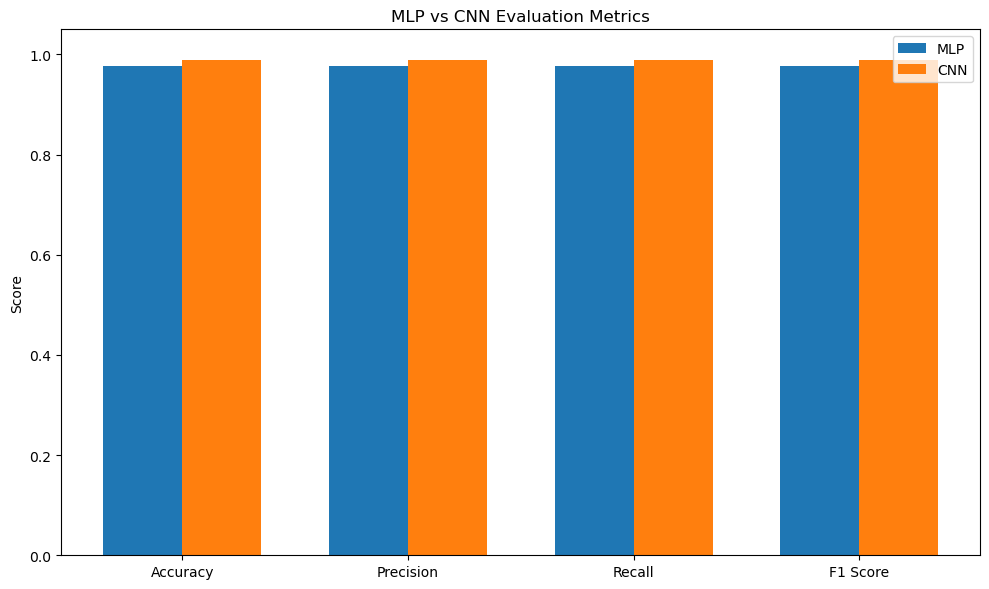


Summary Table of Metrics:
     Accuracy  Precision  Recall  F1 Score  Cross-Entropy Loss
MLP    0.9759     0.9759  0.9759    0.9759              0.8687
CNN    0.9889     0.9889  0.9889    0.9889              0.4001

Metrics saved to results/metrics_summary.csv


<Figure size 640x480 with 0 Axes>

In [14]:
%run evaluate.py